In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, confusion_matrix
from xgboost import XGBClassifier, plot_importance
import shap
from scipy.stats import uniform, randint    
import joblib
import warnings
warnings.filterwarnings("ignore")

C:\Users\Hareesh\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------------
# Load and Split Dataset
# -----------------------------

def load_and_split(data, target_col, test_size=0.20, random_state=42):
    x = data.drop(columns=[target_col])
    y = data[target_col]
    return train_test_split(x, y, test_size=test_size, random_state=random_state)

In [3]:
# -----------------------------
# Cross Validation
# -----------------------------

def cross_validation(x_train, y_train, model, k_folds, model_name='Model'):
    metrics = {'precision' : [], 'recall': [], 'f1': [], 'accuracy' : []}
    for k in k_folds:
        print(f"\n {k} - fold CV for {model_name}")
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        fold_metrics = {'precision' : [], 'recall': [], 'f1': [], 'accuracy' : []}
        for train_idx, val_idx in kf.split(x_train):
            x_tr, x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model.fit(x_tr, y_tr)
            y_pred = model.predict(x_val)
            fold_metrics['precision'].append(precision_score(y_val, y_pred))
            fold_metrics['recall'].append(recall_score(y_val, y_pred))
            fold_metrics['f1'].append(f1_score(y_val, y_pred))
            fold_metrics['accuracy'].append(accuracy_score(y_val, y_pred))
        for m in fold_metrics:
            mean_val = np.mean(fold_metrics[m])
            metrics[m].append(mean_val)
            print(f"{k} - fold {m.capitalize()} : {mean_val:.4f}")
    return metrics

In [4]:
# -----------------------------
# Plotting
# -----------------------------

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()
    
def plot_roc_curve(x_true, y_pred, title='ROC Curve'):
    fpr, tpr,  _ = roc_curve(x_true, y_pred)
    auc_scr = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label= f"AUC - {auc_scr:.2f}", color='orange')
    plt.plot([0,1], [0,1], linestyle='--', color='navy')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_feature_importance(model, title='Feature Importance'):
    plt.figure(figsize=(8, 6))
    plot_importance(model, max_num_features=10)
    plt.title(title)
    plt.show()

def plot_shap_values(model, x, title='SHAP feature importance'):
    explainer = shap.Explainer(model,x)
    shap_val = explainer.shap_values(x)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_val, x, plot_type='bar', show=False)
    plt.title(title)
    plt.show()

In [5]:
# -----------------------------
# Hyperparameter Tuning
# -----------------------------

def tune_xgboost(x_train, y_train):
    param_dict = {
        'n_estimators' : randint(50, 150),
        'max_depth' : randint(3, 10),
        'learning_rate' : uniform(0.01, 0.3),
        'subsample' : uniform(0.7, 0.3), 
        'colsample_bytree' :uniform(0.7, 0.3),
    }
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    rand_search = RandomizedSearchCV(xgb, param_dict, n_iter=15, cv=5, scoring='accuracy',random_state=42,  n_jobs=-1)
    rand_search.fit(x_train, y_train)
    print("\nBest Parameters from RandomizedSearchCV:")
    print(rand_search.best_params_)
    return rand_search.best_estimator_

In [6]:
# -----------------------------
# Main Pipeline Function
# -----------------------------

def main_pipeline(data, target_col):
    x_train, x_test, y_train, y_test = load_and_split(data, target_col)
    
    print('[1] Base Model Evaluation')
    base_model = XGBClassifier(use_lable_encoder=False, eval_metric='logloss', random_state=42)
    cross_validation(x_train, y_train, base_model, [5, 6, 7], model_name='Base Model')
    
    print('[2] Hyperparameter Tuning')
    tuned_model = tune_xgboost(x_train, y_train)
    
    print('[3] Tuned Model Cross-Validation')
    cross_validation(x_train, y_train, tuned_model, [5,6,7], model_name='Tuned Model')
    
    tuned_model.fit(x_train, y_train)
    y_pred = tuned_model.predict(x_test)
    y_prob = tuned_model.predict_proba(x_test)[:, 1]    
    
    print('[4] Final Accuracy Metrics on Test Set')
    print(f'accurac : {accuracy_score(y_test, y_pred):.4f}')
    print(f'precision : {precision_score(y_test, y_pred):.4f}')
    print(f'recall : {recall_score(y_test, y_pred):.4f}')
    print(f'f1 : {f1_score(y_test, y_pred):.4f}')
    
    
    plot_confusion_matrix(y_test, y_pred, 'confusion_matrix - FINAL MODEL')
    plot_roc_curve(y_test, y_pred, 'roc_curve - FINAL MODEL')
    plot_feature_importance(tuned_model, 'Feature Importance - FINAL MODEL')
    plot_shap_values(tuned_model, x_train, 'SHAP Values - FINAL MODEL')
    
    return tuned_model, x_train.columns

In [ ]:
# -----------------------------
# Predict for New Patient
# -----------------------------

def predict_new_patient(model, feature_col):
    new_patient = pd.DataFrame([{
        # 'age': 72,
        # 'Gender': 0,
        # 'Smoking': 0,
        # 'Hx Smoking': 0,
        # 'Hx Radiothreapy': 1,
        # 'Focality': 1,
        # 'Risk': 1,
        # 'T': 0,
        # 'N': 0,
        # 'M': 1,
        # 'Stage': 1,
        # 'Thyroid Function_Euthyroid': 1,
        # 'Physical Examination_Multinodular goiter': 1,
        # 'Adenopathy_No': 1,
        # 'Pathology_Papillary': 1,
        # 'Response_Excellent': 1
        
        'Age' : 50,
        'Gender':0,
        'Smoking' : 0,
        'Hx_Smoking' : 0,
        'Hx_Radiotherapy': 1,
        'Thyroid_Function' : 0,
        'Physical_Examination':0,
        'Adenopathy':1,
        'Pathology' : 1,
        'Focality' :0,
        'Risk' :1 ,
        'T':2,
        'N' :0,
        'M': 1,
        'Stage' : 1,
        'Response' : 1,
        
        # 'Gender': {'Male': 1, 'Female': 0},
        # 'Smoking': {'Yes': 1, 'No': 0},
        # 'Hx_Smoking': {'Yes': 1, 'No': 0},
        # 'Hx_Radiotherapy': {'Yes': 1, 'No': 0},
        # 'Thyroid_Function': {'Normal': 0, 'Abnormal': 1},
        # 'Physical_Examination': {'Normal': 0, 'Abnormal': 1},
        # 'Adenopathy': {'No': 0, 'Yes': 1},
        # 'Pathology': {'Papillary': 0, 'Follicular': 1, 'Medullary': 2, 'Anaplastic': 3},
        # 'Focality': {'Unifocal': 0, 'Multifocal': 1},
        # 'Risk': {'Low': 0, 'Intermediate': 1, 'High': 2},
        # 'T': {'T1': 1, 'T2': 2, 'T3': 3, 'T4': 4},
        # 'N': {'N0': 0, 'N1': 1},
        # 'M': {'M0': 0, 'M1': 1},
        # 'Stage': {'I': 1, 'II': 2, 'III': 3, 'IV': 4},
        # 'Response': {'Positive': 2, 'Stable': 1, 'Negative': 0},
    }])
    
    for col in feature_col:
        if col not in new_patient.columns:
            new_patient[col] = 0
            
    new_patient = new_patient[feature_col]
    
    prediction = model.predict(new_patient)[0]
    prob = model.predict_proba(new_patient)[0][1]
    result = 'Recurred' if prediction == 1 else 'Not Recurred'
    
    
    print('[5] New Patient Prediction')
    print(f"Prediction : {result}")
    print(f"Probability of Recurrence : {prob:.4f}")

[1] Base Model Evaluation

 5 - fold CV for Base Model
5 - fold Precision : 0.9611
5 - fold Recall : 0.9095
5 - fold F1 : 0.9338
5 - fold Accuracy : 0.9622

 6 - fold CV for Base Model
6 - fold Precision : 0.9360
6 - fold Recall : 0.9234
6 - fold F1 : 0.9284
6 - fold Accuracy : 0.9588

 7 - fold CV for Base Model
7 - fold Precision : 0.9239
7 - fold Recall : 0.9153
7 - fold F1 : 0.9176
7 - fold Accuracy : 0.9519
[2] Hyperparameter Tuning

Best Parameters from RandomizedSearchCV:
{'colsample_bytree': 0.7039794883479599, 'learning_rate': 0.29266052670545584, 'max_depth': 8, 'n_estimators': 58, 'subsample': 0.7047898756660642}
[3] Tuned Model Cross-Validation

 5 - fold CV for Tuned Model
5 - fold Precision : 0.9382
5 - fold Recall : 0.9041
5 - fold F1 : 0.9201
5 - fold Accuracy : 0.9553

 6 - fold CV for Tuned Model
6 - fold Precision : 0.9757
6 - fold Recall : 0.9210
6 - fold F1 : 0.9471
6 - fold Accuracy : 0.9690

 7 - fold CV for Tuned Model
7 - fold Precision : 0.9251
7 - fold Recall

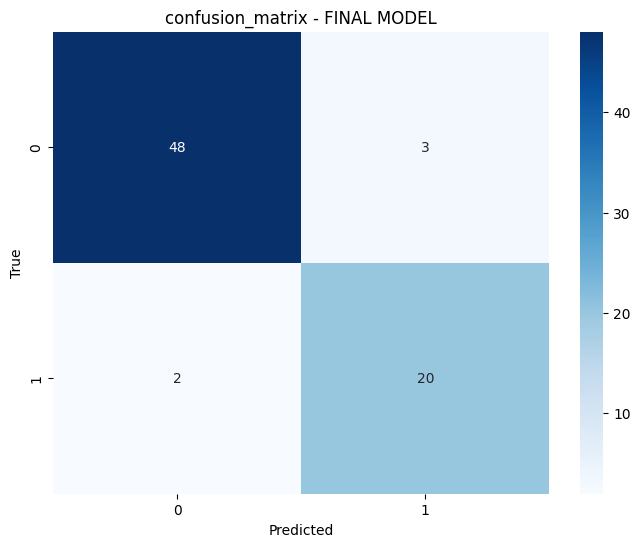

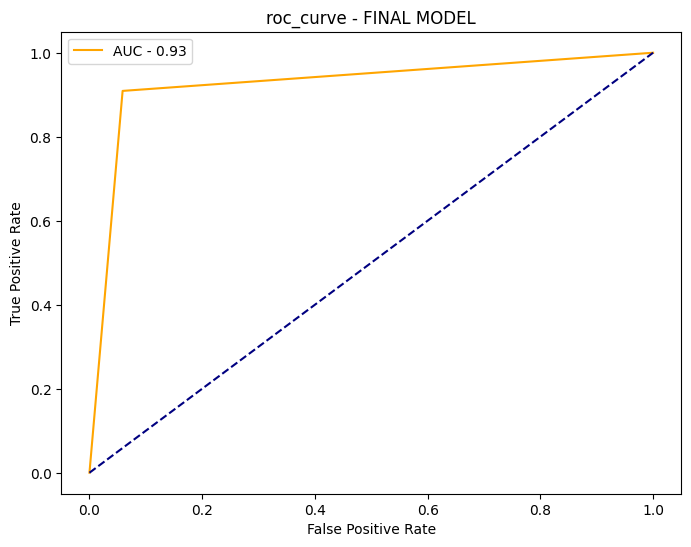

<Figure size 800x600 with 0 Axes>

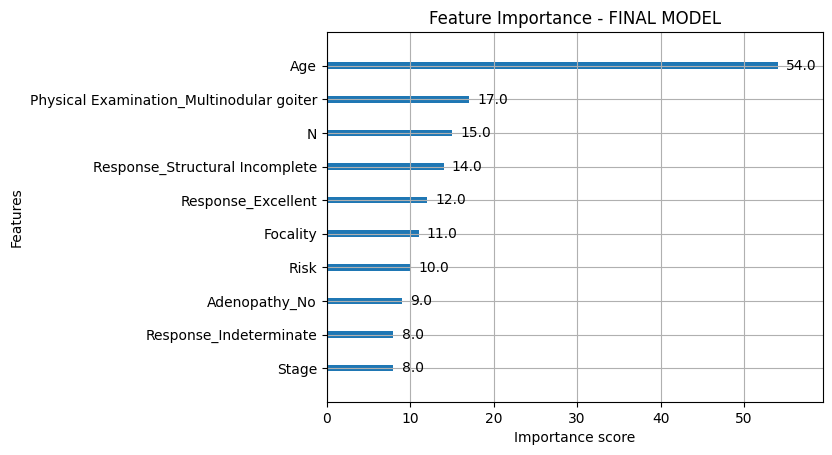

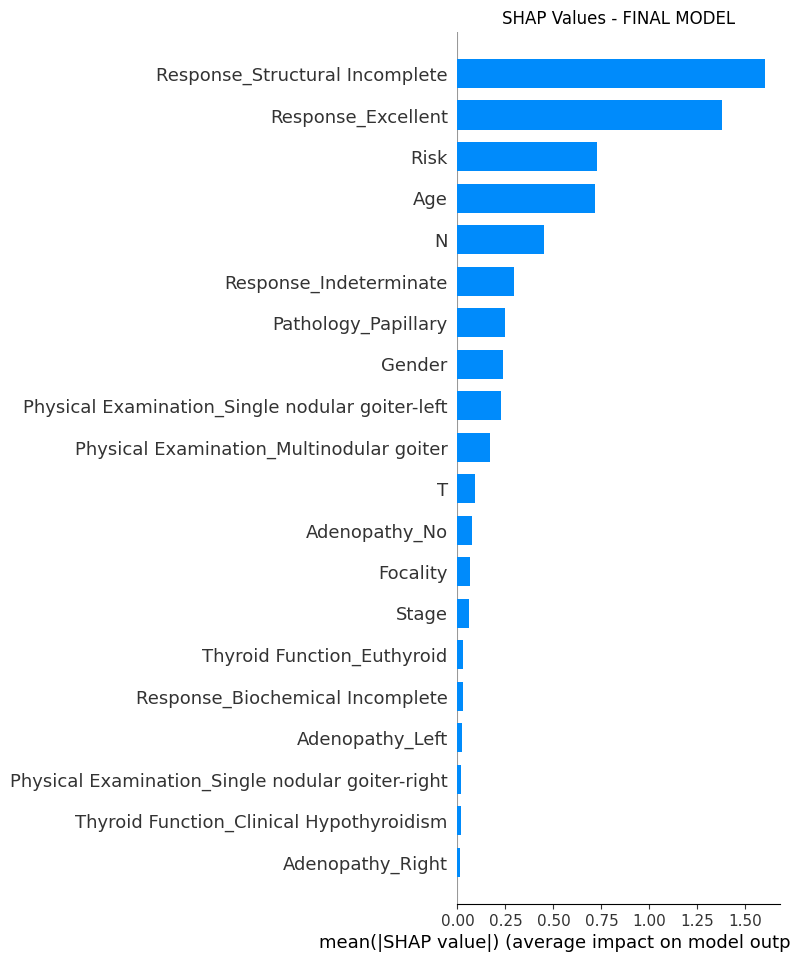

[5] New Patient Prediction
Prediction : Not Recurred
Probability of Recurrence : 0.0737
Prediction : Not Recurred
Model saved successfully.


In [11]:
df = pd.read_csv('Cleaned_dataset.csv')
target = 'Recurred'

model, features = main_pipeline(df, target)
predict_new_patient(model, features)

joblib.dump(model, "recurrence_model.pkl")
print("Model saved successfully.")

Model saved successfully.
